# Model analysis

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [32]:
model_results = pd.read_csv("/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/experiments/results/2025-05-01_09-54_results/results_model_pipeline_content-liking_edge-sim_epochs-10000.csv")

drop_participants_mask = model_results["min_train_loss"].isna()
print("number of participants to drop:",drop_participants_mask.sum())
print("participants to drop:", np.arange(len(drop_participants_mask))[drop_participants_mask])

print('model_results before dropping noncompliant participants:', len(model_results))
model_results = model_results[~drop_participants_mask]
print('model_results after dropping noncompliant participants:', len(model_results))

number of participants to drop: 8
participants to drop: [ 6 13 26 42 59 82 85 96]
model_results before dropping noncompliant participants: 112
model_results after dropping noncompliant participants: 104


In [33]:
model_results_1liking = pd.read_csv("/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/experiments/results/2025-05-09_10-13_results/results_model_pipeline_content-liking_edge-None_epochs-10000.csv")

drop_participants_mask = model_results_1liking["min_train_loss"].isna()
print("number of participants to drop:",drop_participants_mask.sum())
print("participants to drop:", np.arange(len(drop_participants_mask))[drop_participants_mask])

print('model_results before dropping noncompliant participants:', len(model_results_1liking))
model_results_1liking = model_results_1liking[~drop_participants_mask]
print('model_results after dropping noncompliant participants:', len(model_results_1liking))

number of participants to drop: 8
participants to drop: [ 6 13 26 42 59 82 85 96]
model_results before dropping noncompliant participants: 112
model_results after dropping noncompliant participants: 104


In [4]:
model_results.columns.tolist()

['participant',
 'min_train_loss',
 'min_train_mae',
 'min_train_loss_epoch',
 'min_train_mae_epoch',
 'end_epoch',
 'init_src_content_0',
 'trained_src_content_0',
 'init_src_content_1',
 'trained_src_content_1',
 'init_att_src_edge_0',
 'trained_att_src_edge_0',
 'init_src_edge_0',
 'trained_src_edge_0',
 'init_full_src_edge_0',
 'trained_full_src_edge_0',
 'init_dst_content_0',
 'trained_dst_content_0',
 'init_att_dst_edge_0',
 'trained_att_dst_edge_0',
 'init_dst_edge_0',
 'trained_dst_edge_0',
 'init_full_dst_edge_0',
 'trained_full_dst_edge_0',
 'init_att_edge_0',
 'trained_att_edge_0',
 'init_edge_0',
 'trained_edge_0',
 'init_full_edge_0',
 'trained_full_edge_0',
 'init_bias_0',
 'trained_bias_0']

In [5]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=model_results["min_train_mae"],nbinsx=30,name="liking_pos/neg"))
fig.add_trace(go.Histogram(x=model_results_1liking["min_train_mae"],nbinsx=30,name="1liking"))
fig.update_layout(
    title_text='Distribution of MAE among participants', # title of plot
    xaxis_title_text='Minimum Train MAE', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [7]:
model_results[["min_train_mae","trained_src_content_0","trained_src_content_1","trained_full_edge_0"]].describe()

,min_train_mae,trained_src_content_0,trained_src_content_1,trained_full_edge_0
count,1.040000e+02,104.000000,104.000000,104.000000
mean,2.468654e-01,-22.150611,-2.713650,-5.132181
std,2.068545e-01,66.652878,4.976074,38.037942
min,1.005828e-07,-591.296875,-32.140694,-275.468811
25%,9.986345e-02,-20.396856,-5.161769,-5.167854
50%,2.193161e-01,-5.857933,-0.894182,-1.173750
75%,3.338257e-01,-0.350691,0.955374,-0.419585
max,1.391525e+00,1.263268,1.274428,104.514702


In [8]:
fig = go.Figure(data=[go.Histogram(x=model_results["trained_src_content_0"])])
fig.update_layout(
    title_text='Distribution of trained_src_content_0 among participants', # title of plot
    xaxis_title_text='trained_src_content_0', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [9]:
fig = go.Figure(data=[go.Histogram(x=model_results["trained_src_content_1"])])
fig.update_layout(
    title_text='Distribution of trained_src_content_1 among participants', # title of plot
    xaxis_title_text='trained_src_content_1', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [10]:
fig = go.Figure(data=[go.Histogram(x=model_results["trained_full_edge_0"],nbinsx=160)])
fig.update_layout(
    title_text='Distribution of trained_full_edge_0 among participants', # title of plot
    xaxis_title_text='trained_full_edge_0', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [11]:
# from src/loading.py
def load_data():
    print("== Load Data: start ==")
    data = pd.read_excel("/home/julien-rsbrg/Documents/UCL/SemanticToLiking/data/paired_data_newSim.xlsx")
    _temp = data["word_pair"].str.split(".")
    data["word1"] = _temp.apply(func=lambda x: x[0])
    data["word2"] = _temp.apply(func=lambda x: x[1][1:])

    print("== Load Data: end ==")
    return data

data = load_data()

== Load Data: start ==
== Load Data: end ==


In [12]:
# from processing/raw_data_cleaning.py

def build_node_table(complete_data_table:pd.DataFrame,
                     feature_names:list[str],
                     distinct_id:list[str]=[]) -> pd.DataFrame:
    """
    Careful: it keeps the first row of features related to a word if distinct_id is not given    
    """
    
    word1_feature_names = ["word1_%s"%fname for fname in feature_names]
    extracted_features_word1 = complete_data_table[distinct_id+["word1"]+word1_feature_names]
    col_renaming = {"word1":"word"}
    col_renaming.update({word1_feature_names[i]:feature_names[i] for i in range(len(feature_names))})
    extracted_features_word1.rename(columns=col_renaming,inplace=True)

    # in case the complete_data_table doesn't contain an undirected graph
    word2_feature_names = ["word2_%s"%fname for fname in feature_names]
    extracted_features_word2 = complete_data_table[distinct_id+["word2"]+word2_feature_names]
    col_renaming = {"word2":"word"}
    col_renaming.update({word2_feature_names[i]:feature_names[i] for i in range(len(feature_names))})
    extracted_features_word2.rename(columns=col_renaming,inplace=True)

    node_data_table = pd.concat([extracted_features_word1,extracted_features_word2],axis=0)

    node_data_table.drop_duplicates(subset=distinct_id+["word"],keep="first",inplace=True)
    node_data_table.reset_index(inplace=True,drop=True)
    return node_data_table

node_data_table = build_node_table(data,["liking","experience"],["participant"])
node_data_table["experienced"] = node_data_table["experience"] > 0
node_data_table["one"] = 1 
participant_n_not_experienced = node_data_table.groupby("participant")["one"].sum() - node_data_table.groupby("participant")["experienced"].sum()
participant_n_not_experienced = participant_n_not_experienced.rename("n_not_experienced")
participant_n_not_experienced

/tmp/ipykernel_20160/627270167.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_20160/627270167.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



participant
1       9
2       9
3       6
4      18
5      21
       ..
108     9
109     5
110     2
111     9
112     7
Name: n_not_experienced, Length: 112, dtype: int64

In [13]:
participant_data = data[["participant","depression","depressionCont","female","age"]].drop_duplicates(inplace=False).reset_index(drop=True)
participant_data = pd.merge(participant_data,participant_n_not_experienced,on="participant")
participant_data

,participant,depression,depressionCont,female,age,n_not_experienced
0,1,0,12,1,29,9
1,2,0,0,0,41,9
2,3,0,13,1,38,6
3,4,1,31,0,67,18
4,5,0,5,0,40,21
...,...,...,...,...,...,...
107,108,1,36,0,22,9
108,109,0,13,0,21,5
109,110,0,2,1,20,2
110,111,1,15,1,34,9


In [14]:
params_data = model_results[["participant","min_train_mae","trained_src_content_0","trained_src_content_1","trained_full_edge_0"]]
params_data

,participant,min_train_mae,trained_src_content_0,trained_src_content_1,trained_full_edge_0
0,1,0.119404,-11.002692,-5.298422,-5.139972
1,2,0.059272,-5.856982,-10.577765,-0.161807
2,3,0.014073,-4.866621,-5.150636,-1.307598
3,4,0.326171,-36.303043,-2.645650,-4.682124
4,5,0.234990,-591.296875,-1.892469,-1.104515
...,...,...,...,...,...
107,108,0.284512,-22.596487,-0.701754,-5.693655
108,109,0.351327,-0.651787,0.969622,-5.145627
109,110,0.137896,0.979389,0.249697,-1.164464
110,111,0.261863,-19.926456,-0.730878,-1.298139


In [15]:
participant_params_data = pd.merge(participant_data,params_data,on="participant",how="right")
participant_params_data

,participant,depression,depressionCont,female,age,n_not_experienced,min_train_mae,trained_src_content_0,trained_src_content_1,trained_full_edge_0
0,1,0,12,1,29,9,0.119404,-11.002692,-5.298422,-5.139972
1,2,0,0,0,41,9,0.059272,-5.856982,-10.577765,-0.161807
2,3,0,13,1,38,6,0.014073,-4.866621,-5.150636,-1.307598
3,4,1,31,0,67,18,0.326171,-36.303043,-2.645650,-4.682124
4,5,0,5,0,40,21,0.234990,-591.296875,-1.892469,-1.104515
...,...,...,...,...,...,...,...,...,...,...
99,108,1,36,0,22,9,0.284512,-22.596487,-0.701754,-5.693655
100,109,0,13,0,21,5,0.351327,-0.651787,0.969622,-5.145627
101,110,0,2,1,20,2,0.137896,0.979389,0.249697,-1.164464
102,111,1,15,1,34,9,0.261863,-19.926456,-0.730878,-1.298139


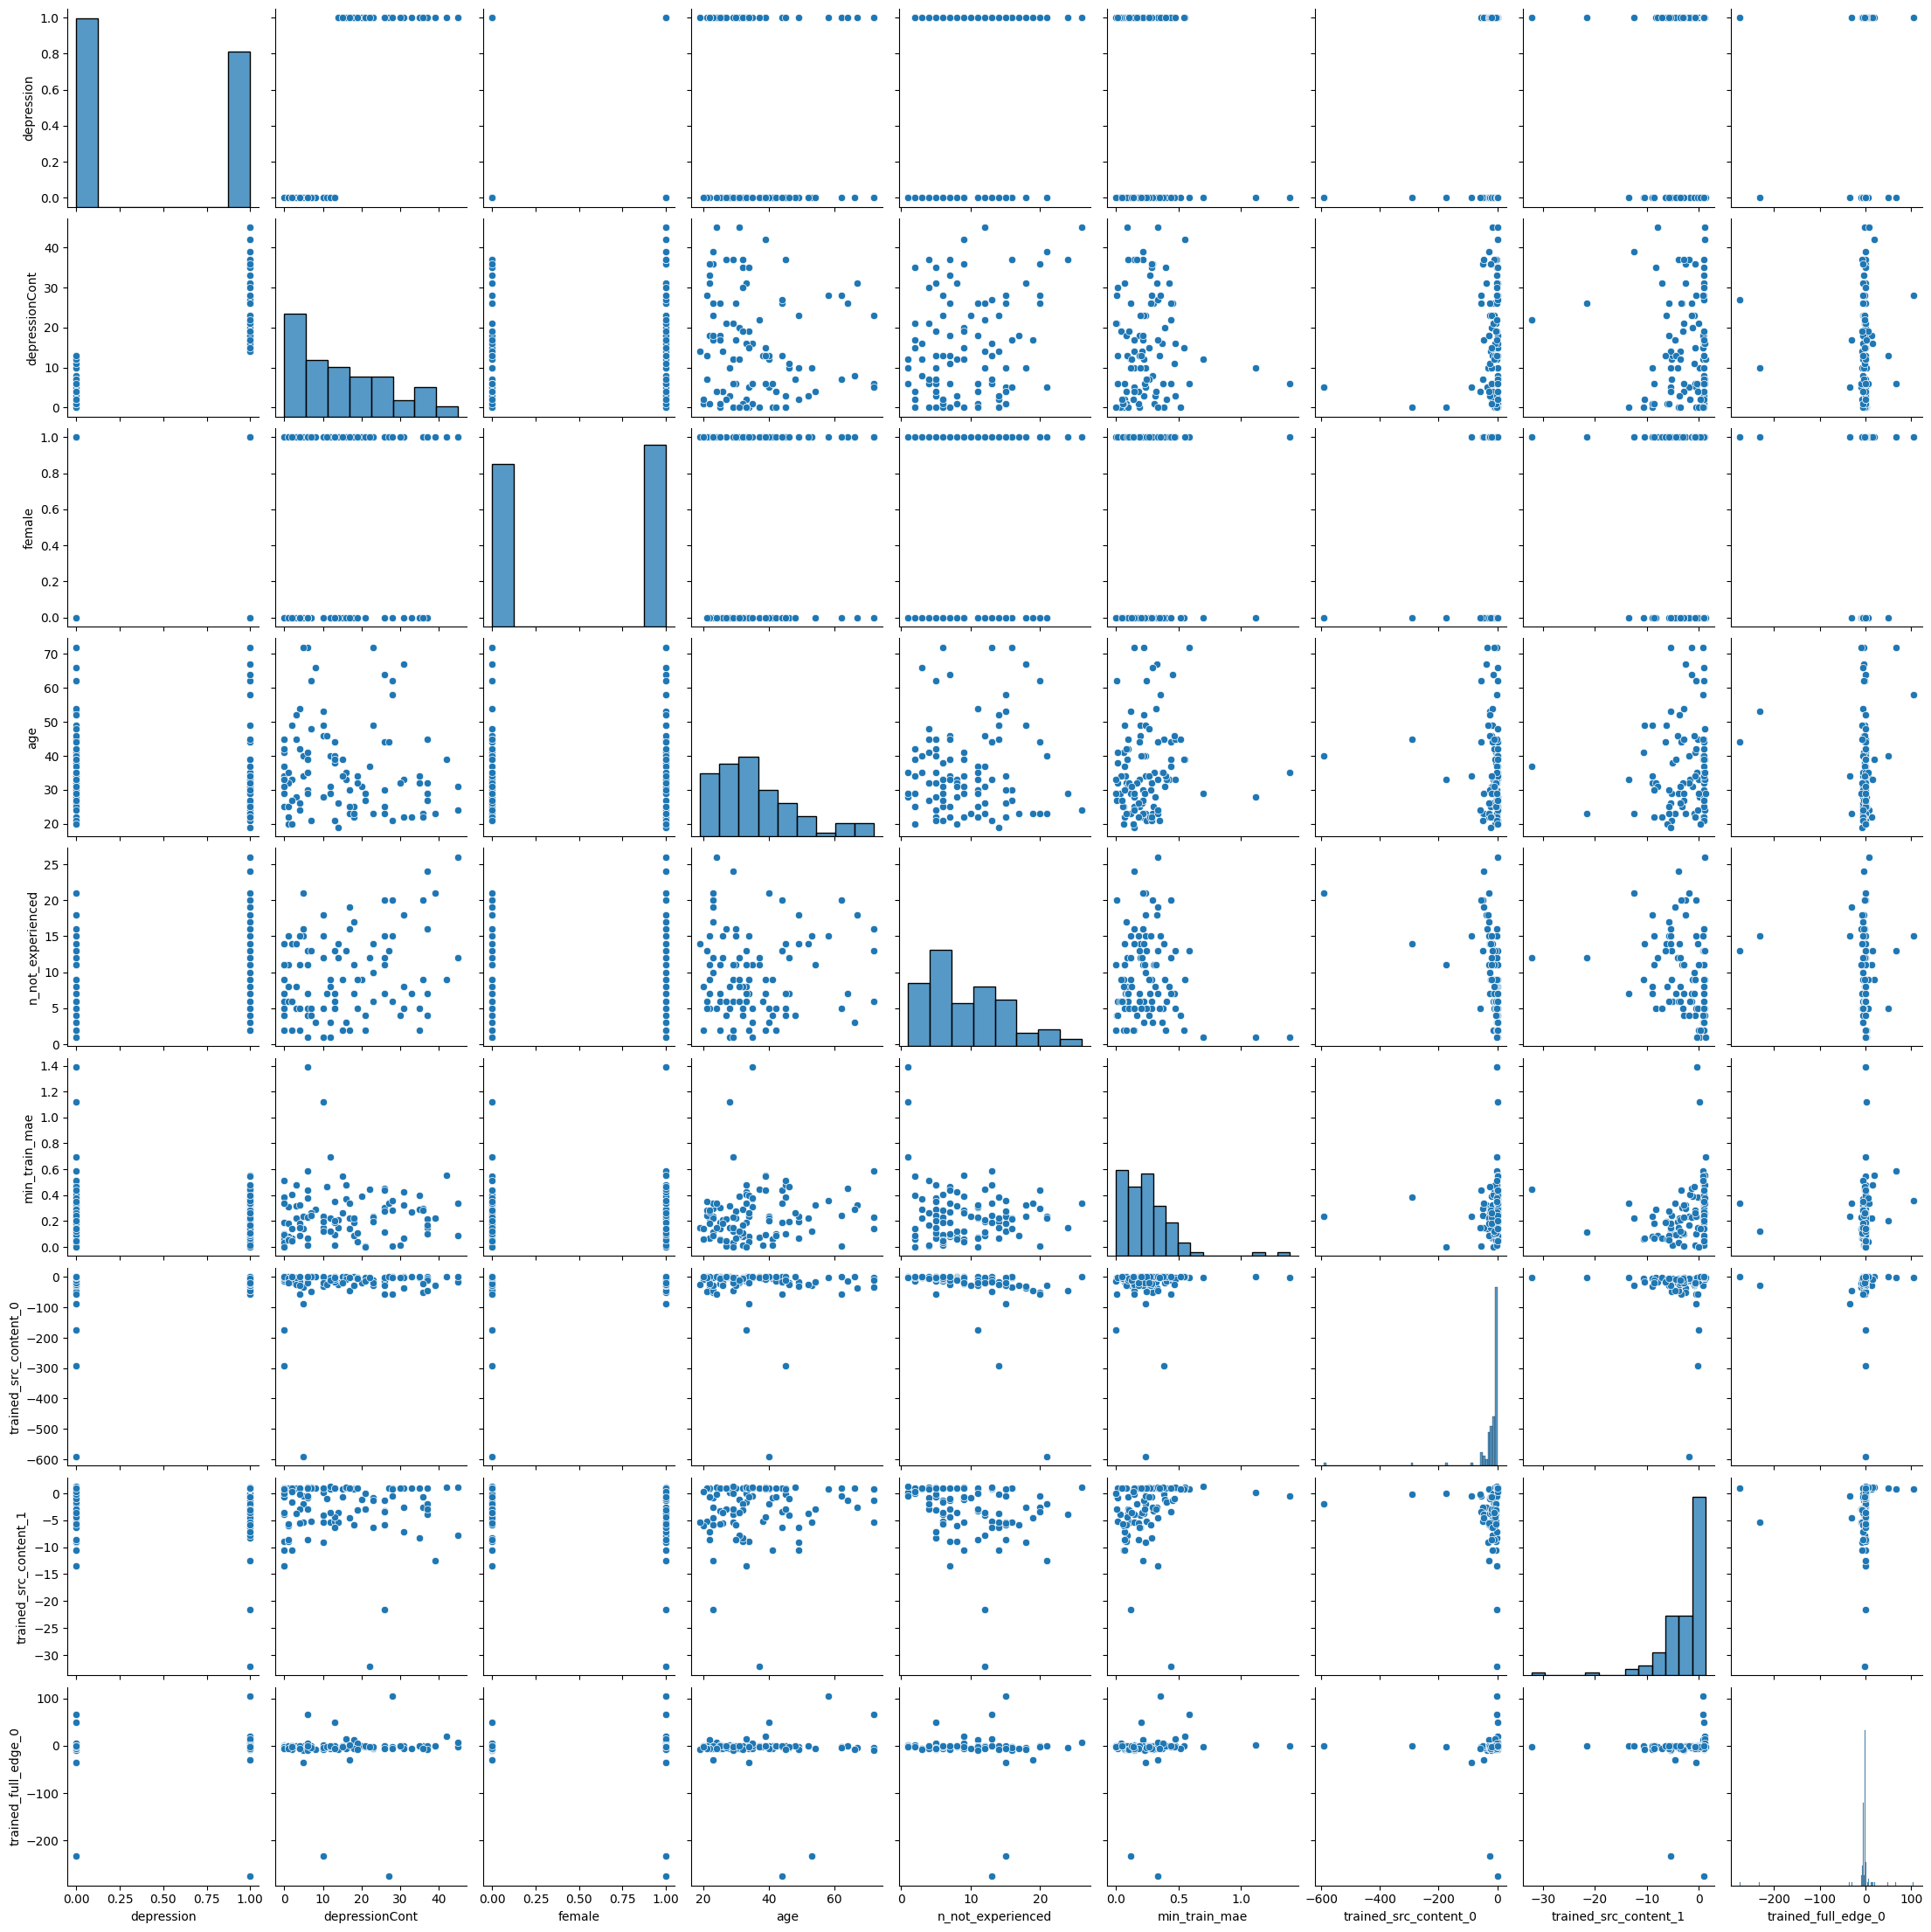

In [16]:
sns.pairplot(participant_params_data[["depression","depressionCont","female","age","n_not_experienced","min_train_mae","trained_src_content_0","trained_src_content_1","trained_full_edge_0"]])

In [17]:
import plotly.express as px

fig = px.scatter(participant_params_data,x="min_train_mae",y="trained_full_edge_0")
fig.show()

In [18]:
participant_params_data[participant_params_data["min_train_mae"]>0.6]

,participant,depression,depressionCont,female,age,n_not_experienced,min_train_mae,trained_src_content_0,trained_src_content_1,trained_full_edge_0
13,16,0,10,0,28,1,1.119270,0.681111,0.142136,0.914463
64,70,0,6,1,35,1,1.391525,-0.990101,-0.435925,0.426397
88,96,0,12,0,29,1,0.695763,-1.118765,1.274428,-1.183036


In [19]:
participant_params_data[participant_params_data["trained_src_content_0"]<-100]

,participant,depression,depressionCont,female,age,n_not_experienced,min_train_mae,trained_src_content_0,trained_src_content_1,trained_full_edge_0
4,5,0,5,0,40,21,0.234990,-591.296875,-1.892469,-1.104515
7,9,0,0,0,45,14,0.384494,-291.863770,-0.220690,-0.439795
71,77,0,0,0,33,11,0.000181,-175.561478,-0.059375,-1.137345


In [20]:
participant_params_data[participant_params_data["trained_src_content_1"]<-20]

,participant,depression,depressionCont,female,age,n_not_experienced,min_train_mae,trained_src_content_0,trained_src_content_1,trained_full_edge_0
50,55,1,26,1,23,12,0.115053,-0.990389,-21.537334,-0.675824
55,61,1,22,1,37,12,0.441642,-1.458529,-32.140694,-2.182625


In [22]:
results = smf.ols('depressionCont ~ 0 + trained_src_content_1', data=participant_params_data).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:         depressionCont   R-squared (uncentered):                   0.147
Model:                            OLS   Adj. R-squared (uncentered):              0.139
Method:                 Least Squares   F-statistic:                              17.73
Date:                Tue, 13 May 2025   Prob (F-statistic):                    5.47e-05
Time:                        19:20:54   Log-Likelihood:                         -447.71
No. Observations:                 104   AIC:                                      897.4
Df Residuals:                     103   BIC:                                      900.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [23]:
import numpy as np
np.corrcoef(participant_params_data["depressionCont"],participant_params_data["trained_src_content_1"])

array([[ 1.        , -0.02818514],
       [-0.02818514,  1.        ]])

## 1 liking

In [24]:
params_data = model_results_1liking[["participant","min_train_mae","trained_src_content_0"]]
params_data

,participant,min_train_mae,trained_src_content_0
0,1,0.749925,-0.433152
1,2,1.167308,-0.721298
2,3,0.113637,-4.942300
3,4,0.604707,0.954146
4,5,0.357409,0.987858
...,...,...,...
107,108,0.537559,0.924092
108,109,0.348227,0.969621
109,110,0.137683,0.979383
110,111,0.580603,0.928168


In [25]:
participant_params_data = pd.merge(participant_data,params_data,on="participant",how="right")
participant_params_data

,participant,depression,depressionCont,female,age,n_not_experienced,min_train_mae,trained_src_content_0
0,1,0,12,1,29,9,0.749925,-0.433152
1,2,0,0,0,41,9,1.167308,-0.721298
2,3,0,13,1,38,6,0.113637,-4.942300
3,4,1,31,0,67,18,0.604707,0.954146
4,5,0,5,0,40,21,0.357409,0.987858
...,...,...,...,...,...,...,...,...
99,108,1,36,0,22,9,0.537559,0.924092
100,109,0,13,0,21,5,0.348227,0.969621
101,110,0,2,1,20,2,0.137683,0.979383
102,111,1,15,1,34,9,0.580603,0.928168


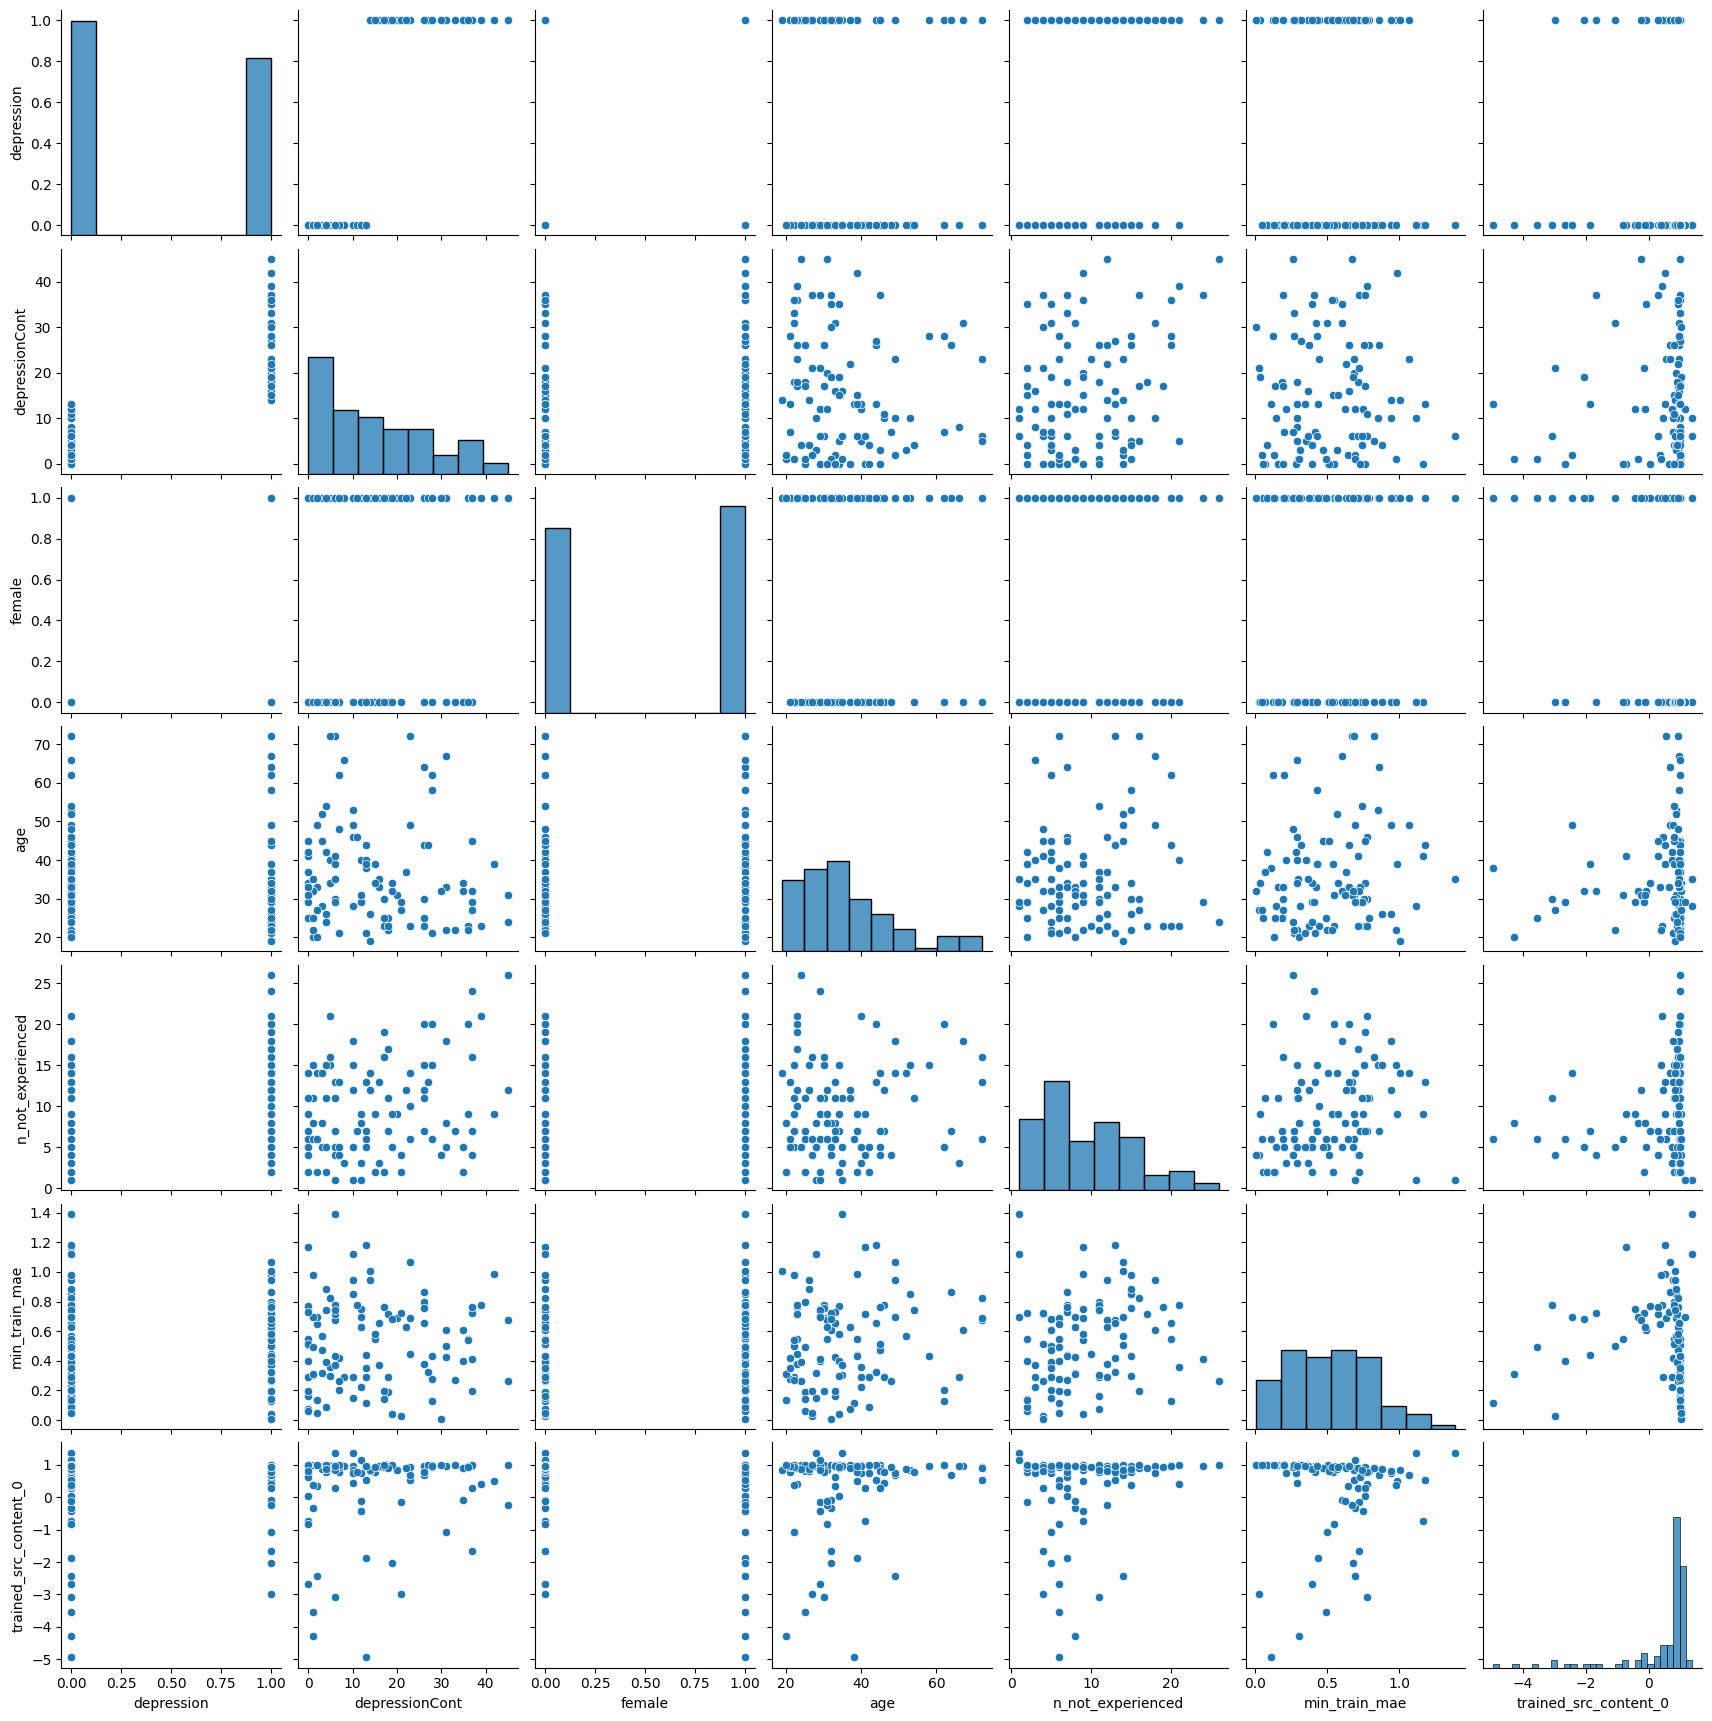

In [26]:
sns.pairplot(participant_params_data[["depression","depressionCont","female","age","n_not_experienced","min_train_mae","trained_src_content_0"]])

In [27]:
results = smf.ols('depressionCont ~ 1 + n_not_experienced + min_train_mae * trained_src_content_0', data=participant_params_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         depressionCont   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.212
Date:                Tue, 13 May 2025   Prob (F-statistic):             0.0731
Time:                        19:21:08   Log-Likelihood:                -405.90
No. Observations:                 104   AIC:                             821.8
Df Residuals:                      99   BIC:                             835.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

# No liking param, only similarity param

In [ ]:
model_results_no_liking_param = pd.read_csv("/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/experiments/results/2025-05-13_19-38_results/results_model_pipeline_content-identity_edge-sim_epochs-10000.csv")

drop_participants_mask = model_results_no_liking_param["min_train_loss"].isna()
print("number of participants to drop:",drop_participants_mask.sum())
print("participants to drop:", np.arange(len(drop_participants_mask))[drop_participants_mask])

print('model_results before dropping noncompliant participants:', len(model_results_no_liking_param))
model_results_no_liking_param = model_results_no_liking_param[~drop_participants_mask]
print('model_results after dropping noncompliant participants:', len(model_results_no_liking_param))

FileNotFoundError: [Errno 2] No such file or directory: '/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/experiments/results/2025-05-13_17-38_results/results_model_pipeline_content-identity_edge-sim_epochs-10000.csv'

In [50]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=model_results["min_train_mae"],nbinsx=30,name="liking_pos/neg"))
fig.add_trace(go.Histogram(x=model_results_no_liking_param["min_train_mae"],nbinsx=30,name="no liking param"))
fig.update_layout(
    title_text='Distribution of MAE among participants', # title of plot
    xaxis_title_text='Minimum Train MAE', # xaxis label
    yaxis_title_text='Count', # yaxis label
)
fig.show()

In [51]:
params_data = model_results_no_liking_param[["participant","min_train_mae","init_src_content_0","trained_src_content_0","trained_full_edge_0"]]
params_data

,participant,min_train_mae,init_src_content_0,trained_src_content_0,trained_full_edge_0
0,1,0.839453,1.0,1.0,-7.367063e-02
1,2,1.443522,1.0,1.0,1.333471e+00
2,3,1.012385,1.0,1.0,1.615954e-01
3,4,0.647634,1.0,1.0,-2.033676e-02
4,5,0.501295,1.0,1.0,-3.280699e-02
...,...,...,...,...,...
107,108,0.562553,1.0,1.0,3.632861e+00
108,109,0.416811,1.0,1.0,2.217555e-01
109,110,0.151253,1.0,1.0,5.886391e-07
110,111,0.596608,1.0,1.0,-6.135755e-02


In [52]:
participant_params_data = pd.merge(participant_data,params_data,on="participant",how="right")
participant_params_data

,participant,depression,depressionCont,female,age,n_not_experienced,min_train_mae,init_src_content_0,trained_src_content_0,trained_full_edge_0
0,1,0,12,1,29,9,0.839453,1.0,1.0,-7.367063e-02
1,2,0,0,0,41,9,1.443522,1.0,1.0,1.333471e+00
2,3,0,13,1,38,6,1.012385,1.0,1.0,1.615954e-01
3,4,1,31,0,67,18,0.647634,1.0,1.0,-2.033676e-02
4,5,0,5,0,40,21,0.501295,1.0,1.0,-3.280699e-02
...,...,...,...,...,...,...,...,...,...,...
99,108,1,36,0,22,9,0.562553,1.0,1.0,3.632861e+00
100,109,0,13,0,21,5,0.416811,1.0,1.0,2.217555e-01
101,110,0,2,1,20,2,0.151253,1.0,1.0,5.886391e-07
102,111,1,15,1,34,9,0.596608,1.0,1.0,-6.135755e-02


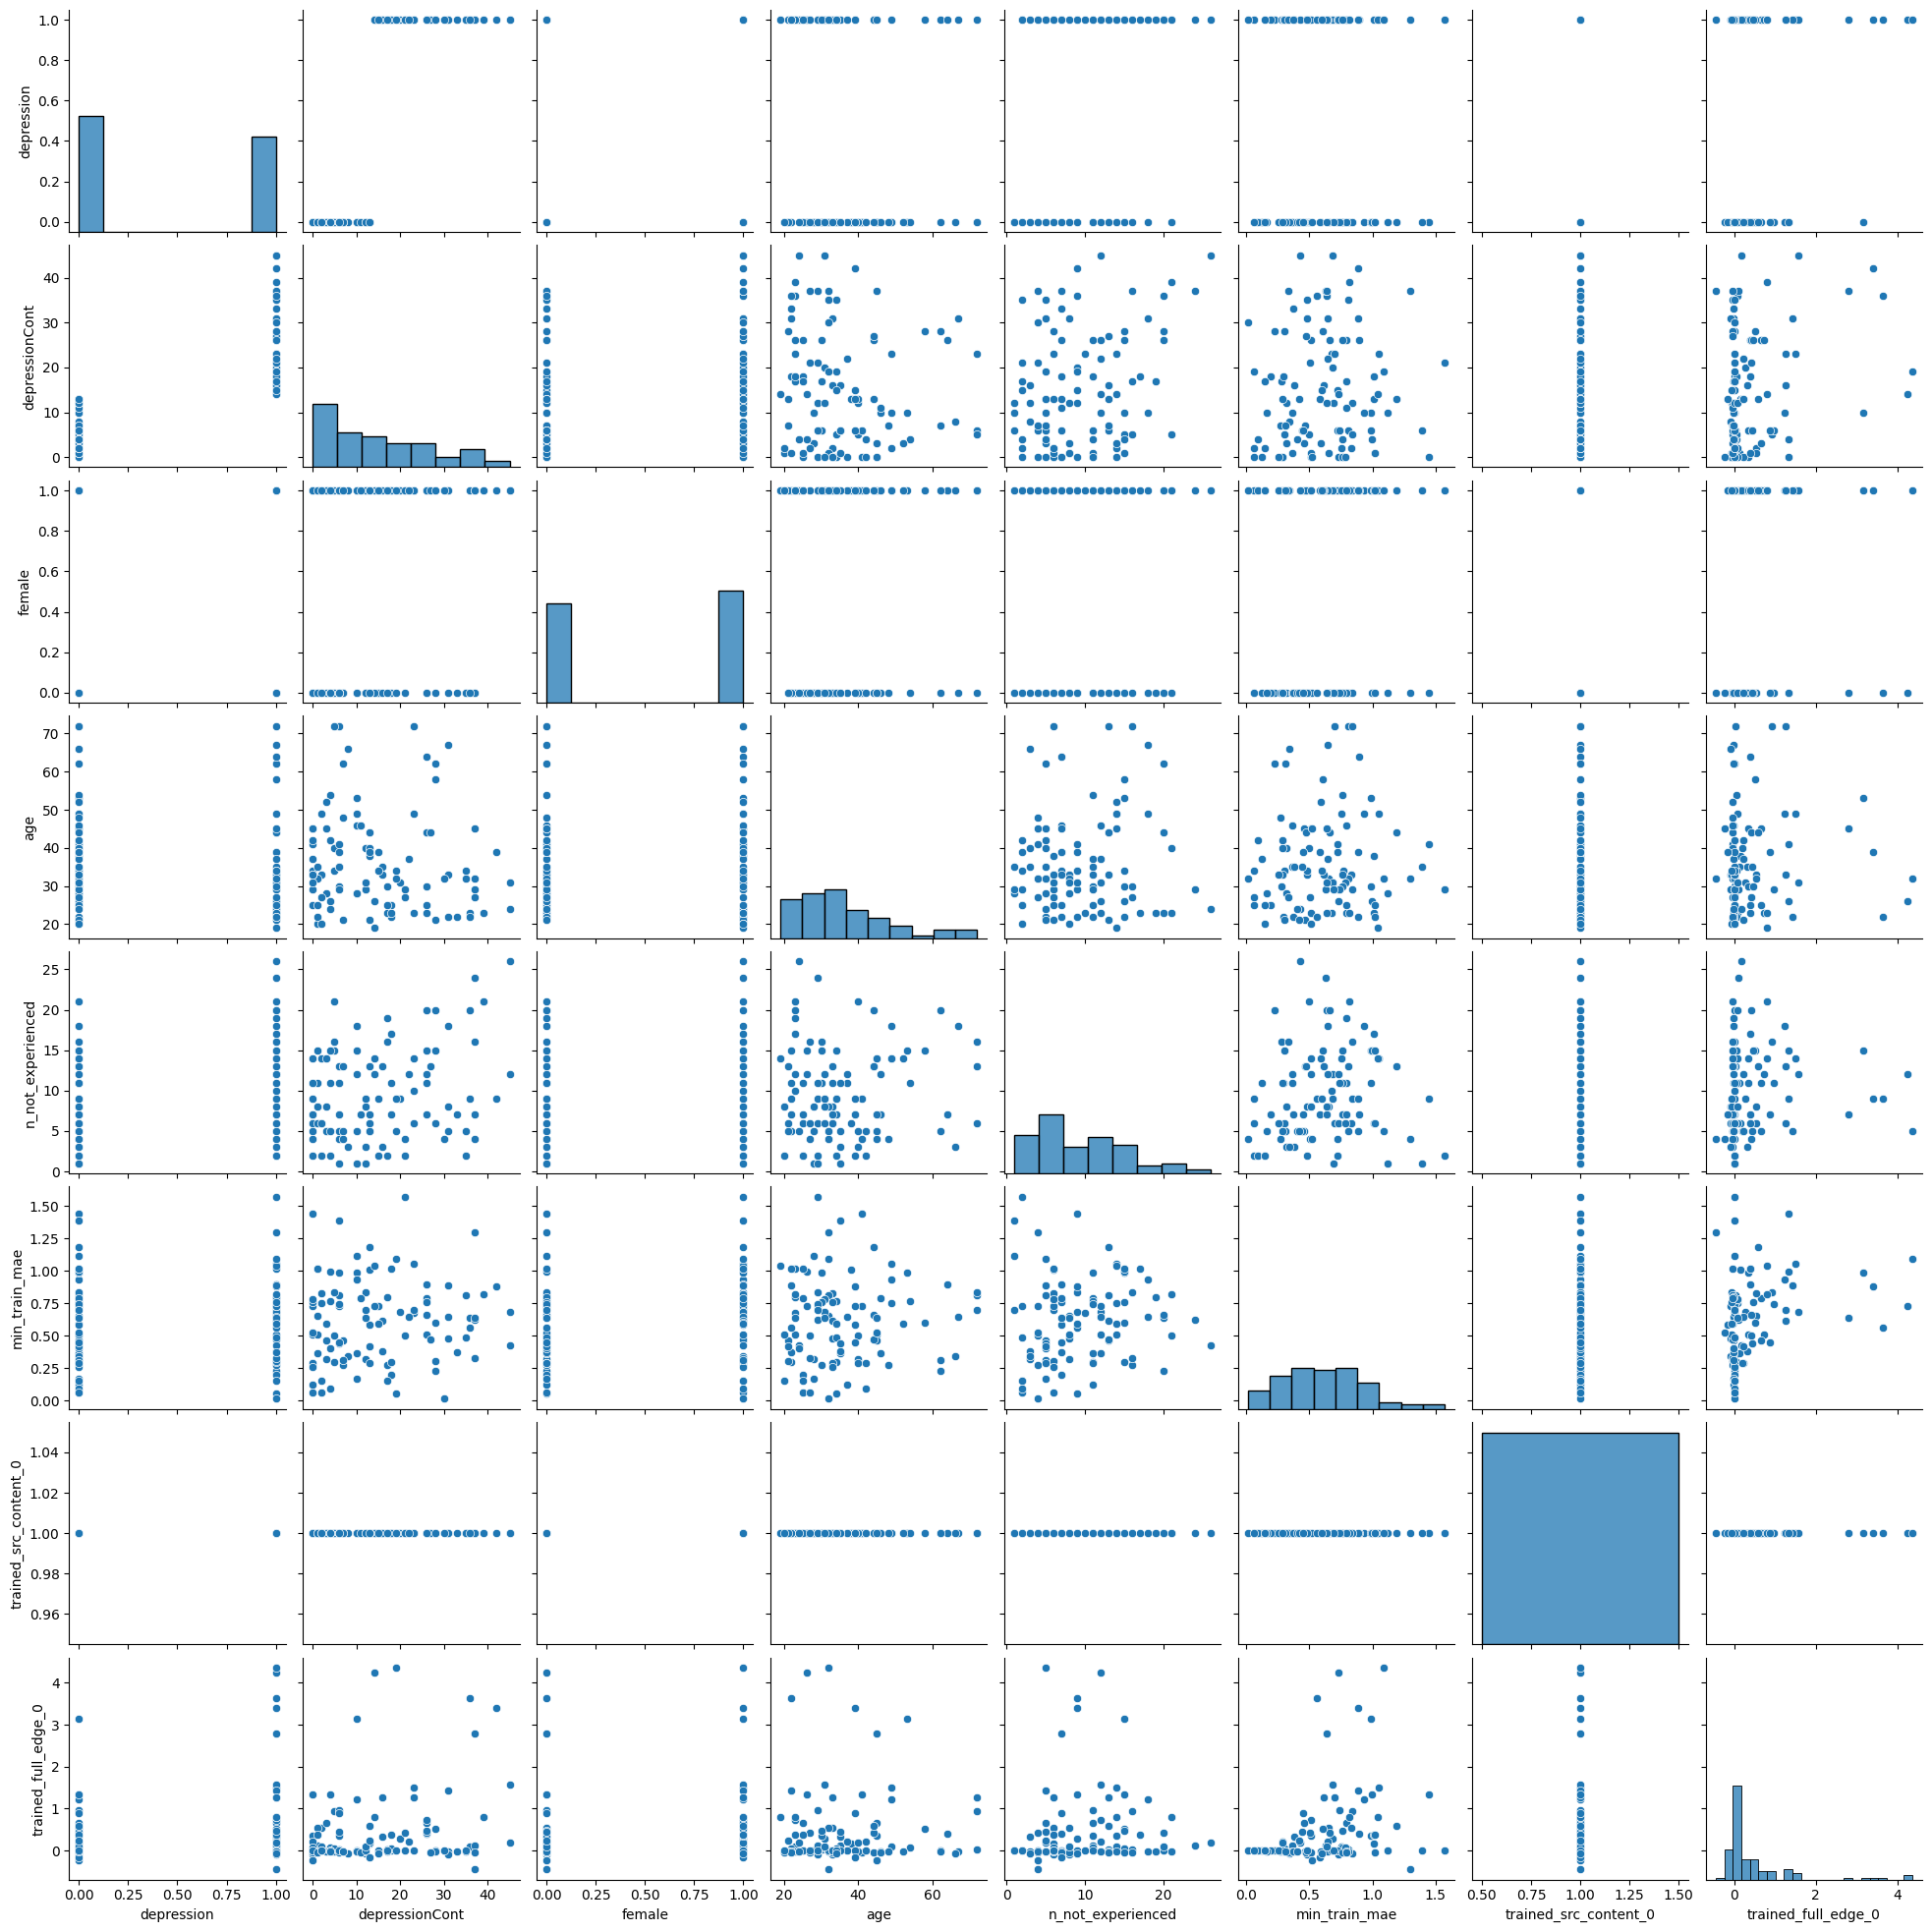

In [53]:
sns.pairplot(participant_params_data[["depression","depressionCont","female","age","n_not_experienced","min_train_mae","trained_src_content_0","trained_full_edge_0"]])

In [47]:
results = smf.ols('depressionCont ~ 1 + n_not_experienced', data=participant_params_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         depressionCont   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     8.433
Date:                Tue, 13 May 2025   Prob (F-statistic):            0.00452
Time:                        20:34:09   Log-Likelihood:                -406.22
No. Observations:                 104   AIC:                             816.4
Df Residuals:                     102   BIC:                             821.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.9617      2.34

In [55]:
results = smf.ols('depressionCont ~ 1 + n_not_experienced + min_train_mae * trained_src_content_0 * trained_full_edge_0', data=participant_params_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         depressionCont   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     4.719
Date:                Tue, 13 May 2025   Prob (F-statistic):            0.00158
Time:                        20:36:49   Log-Likelihood:                -401.28
No. Observations:                 104   AIC:                             812.6
Df Residuals:                      99   BIC:                             825.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [54]:
results = smf.ols('depressionCont ~ 1 + trained_full_edge_0', data=participant_params_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         depressionCont   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     6.155
Date:                Tue, 13 May 2025   Prob (F-statistic):             0.0147
Time:                        20:36:46   Log-Likelihood:                -407.30
No. Observations:                 104   AIC:                             818.6
Df Residuals:                     102   BIC:                             823.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.3776    